In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

### Using scenario 3 (Dataset 44 on the CTU website)     
Please note that these files have been processed using the "Data_processing" notebook, which takes in the original file from the website, preprocesses it, and saves it again in csv file.

In [2]:
DATA_PATH_ORIG = r'../data/scenario_3.csv'

Read the data

In [3]:
df = pd.read_csv(DATA_PATH_ORIG, parse_dates=['start_date'])
df.head()

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label,src_port,dst_port
0,2011-08-12 15:24:01.105,4.677,TCP,74.125.108.243,147.32.86.187,PA_,0,452,682688,1,Background,80,55707
1,2011-08-12 15:24:01.105,3.110,TCP,147.32.84.164,83.208.193.123,PA_,0,5,506,1,LEGITIMATE,22,15173
2,2011-08-12 15:24:01.105,4.678,TCP,147.32.86.187,74.125.108.243,A_,0,106,6510,1,LEGITIMATE,55707,80
3,2011-08-12 15:24:01.106,4.989,TCP,217.168.211.184,147.32.84.14,PA_,0,1393,95812,1,Background,3953,22
4,2011-08-12 15:24:01.113,4.988,UDP,173.9.132.155,147.32.84.59,INT,0,811,680898,1,Background,54369,15046


In [4]:
df.shape

(15202060, 13)

Have a look at the labels we have

In [5]:
df['label'].unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

As we discussed in Mattermost, we are interested in the connections between the **infected** host (it is only one in this dataset) and the other IPs 

### From website: infected host --> 147.32.84.165

In [6]:
host_ip = "147.32.84.165"

## Real distribution of IP addresses
This works as a benchmark, as we stored all the data and compute the frequencies. After this, we will do it with reservoir sampling and compare the obtained results.

Let's keep all the other IPs the host connects with

In [7]:
connections = df[(df['src_addr'] == host_ip) | (df['dst_addr'] == host_ip)][['src_addr', 'dst_addr']]

# the host can be either 'source' or 'destination'
# we want to keep only the other IP address
other_ips = connections.apply(lambda row: row['dst_addr'] if row['src_addr'] == host_ip else row['src_addr'], axis=1)
print(f"{other_ips.size} flows with other IPs found.")

75891 flows with other IPs found.


Just a sanity check to assert that we do not have our host_ip somewhere in the list of IPs

In [8]:
print(len([ip for ip in other_ips if ip != host_ip]))
print(len(other_ips))

75891
75891


Let's compute the real frequencies of other IPs, and let's retain the top 10, as requested

In [9]:
benchmark_counts = other_ips.value_counts().sort_values(ascending=False)
benchmark_counts[:10]

178.77.71.27      12424
38.229.70.20       3828
147.32.96.45       1218
195.113.235.89      723
109.74.55.27        397
64.31.13.148        282
208.86.166.68       282
210.139.61.102      181
208.100.127.34       90
210.139.61.70        72
dtype: int64

# Reservoir sampling (in one pass)
Below are some resources which we found useful when developing the reservoir sampling:
- https://stackoverflow.com/questions/12732982/design-a-storage-algorithm/12733515#12733515     
- https://stackoverflow.com/questions/2612648/reservoir-sampling       
- http://web.archive.org/web/20141026071430/http://propersubset.com:80/2010/04/choosing-random-elements.html

### We are going to test the reservoir sampling using a range of values for the reservoir size   
Intuitively, the higher the size, the better the estimation. However, it requires more memory to store the data    

We are streaming the data, so we just loop ONCE over the dataset. Each row has the 'src' and 'dst' IP.
- If the IP we are monitoring is in the flow, we apply the reservoir sampling.
- If it's not, we discard such flow because it's not of interest for the purpose.

However, if we actually stream the data with 15 million flows, it takes way too much to process it all, especially if we need to try different sizes.

Therefore, since we know we are only interested in the flows which contain the IP of the host (either as 'src' or 'dst') we can filter out all the other flows beforehand, without compromising the reservoir sampling approach.

After that, we perform **one pass** on all the remaining IPs, applying reservoir sampling

In [10]:
df.shape

(15202060, 13)

Keep only flows of interest

In [11]:
connections = df[(df['src_addr'] == host_ip) | (df['dst_addr'] == host_ip)][['src_addr', 'dst_addr']]
other_ips = connections.apply(lambda row: row['dst_addr'] if row['src_addr'] == host_ip else row['src_addr'], axis=1)
other_ips.shape

(75891,)

'other_ips' contains the stream of all the flows of interest (where the host ip appears either as 'src' or 'dst').    
We can now apply reservoir sampling

In [12]:
def reservoir_sampling(stream, reservoir_size):
    stored_items = []
    for N, stream_item in enumerate(stream):
        if N < reservoir_size:
            # as long as we have room, the probability of storing is 100%
            stored_items.append(stream_item)
        else:
            # when N = i+1 we have i IPs stored (i > reservoir_size) 
            # In such a case, we want probability i/i+1 of storing the new IP, substituting one of the stored ones.        
            m = random.randint(0,N)
            if m < reservoir_size:
                stored_items[m] = stream_item
    return pd.Series(stored_items)

For the results, we adopt the recall at the top 10 frequent IPs

In [13]:
def compute_reservoir_error(original, sampled, n_of_ips, verbose=False):
    if verbose:
        print(f"Size of stream: {original.size}. Size of reservoir: {sampled.size}")
    
    original = original.value_counts().sort_values(ascending=False)
    sampled = sampled.value_counts().sort_values(ascending=False)
    
    top_n_to_find = original[:10].index
    top_n_found = sampled[:10].index
        
    retrieved = set.intersection(set(top_n_to_find), set(top_n_found))
    if verbose:
        print(len(retrieved))
    return len(retrieved)

In [30]:
result_list = []
sizes = list(set(np.logspace(1,4.3,num=1000,base=10,dtype='int')))
for reservoir_size in sorted(sizes):
    results = reservoir_sampling(other_ips, reservoir_size)
    res = compute_reservoir_error(other_ips, results, 10)
    result_list.append(res)

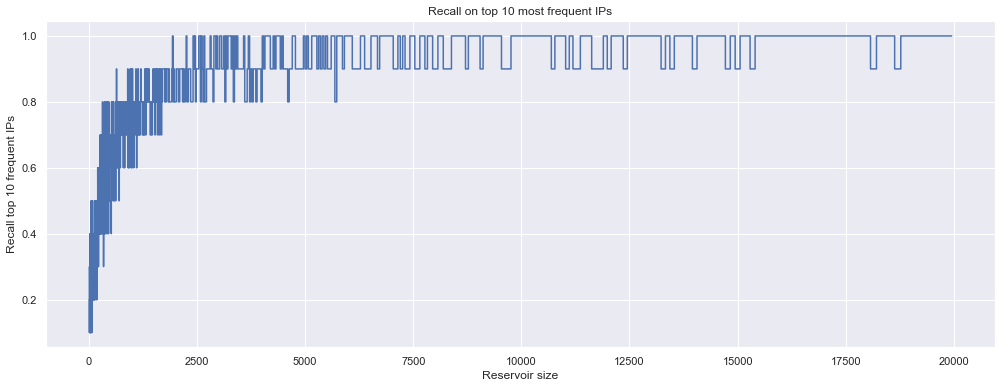

In [40]:
plt.figure(figsize=(17, 6))
plt.plot(sorted(sizes), np.array(result_list)/10, drawstyle='steps')
plt.title("Recall on top 10 most frequent IPs")
plt.xlabel("Reservoir size")
plt.ylabel("Recall top 10 frequent IPs")
plt.show()

## Frequencies with and without reservoir sampling

In [93]:
test_res = reservoir_sampling(other_ips, 10000)
n_rows = test_res.shape[0]
(test_res.value_counts().sort_values(ascending=False)/n_rows)[:10]

178.77.71.27      0.1634
38.229.70.20      0.0513
147.32.96.45      0.0154
195.113.235.89    0.0087
109.74.55.27      0.0064
64.31.13.148      0.0039
210.139.61.102    0.0030
208.86.166.68     0.0028
210.139.61.70     0.0012
208.100.127.34    0.0007
dtype: float64

In [89]:
real_result = other_ips.value_counts().sort_values(ascending=False)
real_result = real_result / other_ips.shape[0]

real_result[:10]

178.77.71.27      0.163708
38.229.70.20      0.050441
147.32.96.45      0.016049
195.113.235.89    0.009527
109.74.55.27      0.005231
64.31.13.148      0.003716
208.86.166.68     0.003716
210.139.61.102    0.002385
208.100.127.34    0.001186
210.139.61.70     0.000949
dtype: float64

We can see that, with reservoir size 10000 (instead of 75891 which is the size we would need to STORE the whole stream of other IPs) we obtain recall 1. This is a nice shot for reservoir sampling :)